In [ ]:
 !pip install -q kaggle
 from google.colab import files

In [ ]:
files.upload()

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#! kaggle datasets list

In [ ]:
!kaggle datasets download -d gunavenkatdoddi/eye-diseases-classification

100% 736M/736M [00:24<00:00, 30.3MB/s]
100% 736M/736M [00:24<00:00, 32.1MB/s]


In [ ]:
!unzip /content/eye-diseases-classification.zip

In [ ]:
# Importing required Libraries:
#import cv2
# import keras
import tensorflow as tf
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
%matplotlib inline

In [ ]:
import tensorflow_hub as hub
import os

In [ ]:
path = '/content/dataset'
address = []
l1 = os.listdir(path)
print(l1)
for i in l1:
  l2 = os.listdir(path +'/'+ i)
  print(l2)
  for n in l2:
    address.append([path+'/'+i+'/'+n,i])

['normal', 'glaucoma', 'cataract', 'diabetic_retinopathy']
['2790_right.jpg', '3198_left.jpg', '3144_left.jpg', '3168_left.jpg', '2944_left.jpg', '3034_right.jpg', '2369_right.jpg', '2985_left.jpg', '3353_left.jpg', '2645_right.jpg', '1253_right.jpg', '2419_left.jpg', '2761_left.jpg', '2659_right.jpg', '2432_right.jpg', '3226_right.jpg', '2393_left.jpg', '3018_right.jpg', '2858_left.jpg', '3273_left.jpg', '3317_left.jpg', '3259_right.jpg', '3001_right.jpg', '2743_left.jpg', '3411_left.jpg', '2940_left.jpg', '3050_left.jpg', '2518_right.jpg', '2647_left.jpg', '1034_right.jpg', '2878_right.jpg', '3170_right.jpg', '2675_left.jpg', '3256_right.jpg', '2563_right.jpg', '3412_right.jpg', '2829_left.jpg', '2547_right.jpg', '3275_left.jpg', '3290_right.jpg', '2470_right.jpg', '2843_right.jpg', '3355_left.jpg', '2948_left.jpg', '3145_left.jpg', '2961_left.jpg', '2808_left.jpg', '3010_left.jpg', '2897_left.jpg', '3095_right.jpg', '2685_left.jpg', '2356_left.jpg', '3172_left.jpg', '2773_right.jpg'

In [ ]:
df = pd.DataFrame(address,columns = ['address', 'group'])
df.head()

,address,group
0,/content/dataset/normal/2790_right.jpg,normal
1,/content/dataset/normal/3198_left.jpg,normal
2,/content/dataset/normal/3144_left.jpg,normal
3,/content/dataset/normal/3168_left.jpg,normal
4,/content/dataset/normal/2944_left.jpg,normal


In [ ]:
df['group'].value_counts()

diabetic_retinopathy    1098
normal                  1074
cataract                1038
glaucoma                1007
Name: group, dtype: int64

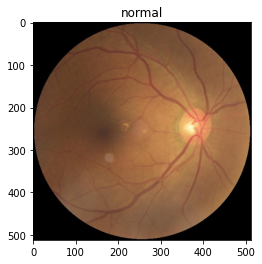

In [ ]:
img = plt.imread(df['address'][0])
plt.title(df['group'][0])
plt.imshow(img)

In [ ]:
img.shape

(512, 512, 3)

In [ ]:
df['label'] = df['group'].map({'cataract': 1,  'normal' : 0 , 'diabetic_retinopathy' : 2,'glaucoma': 3})

In [ ]:
len(df)

4217

In [ ]:
df.head()

,address,group,label
0,/content/dataset/normal/2790_right.jpg,normal,0
1,/content/dataset/normal/3198_left.jpg,normal,0
2,/content/dataset/normal/3144_left.jpg,normal,0
3,/content/dataset/normal/3168_left.jpg,normal,0
4,/content/dataset/normal/2944_left.jpg,normal,0


In [ ]:
unique = np.unique(df['label'])
print(unique)
boolean_labels = [label == unique for label in df['label']]
boolean_labels[:2]

[0 1 2 3]


[array([ True, False, False, False]), array([ True, False, False, False])]

In [ ]:
X = df['address']
y = boolean_labels

In [ ]:
NUM_IMAGES = len(df)

In [ ]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X[:NUM_IMAGES],
                                                 y[:NUM_IMAGES],
                                                 test_size = 0.20,
                                                 random_state =42,
                                                 shuffle =True,
                                                 stratify = y[:NUM_IMAGES])

In [ ]:
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size = 0.20,random_state = 42)

In [ ]:
len(X_train), len(X_val), len(X_test)

(2698, 675, 844)

In [ ]:
img_size = 224
def process_images(image_path, img_size = img_size):

  img = tf.io.read_file(image_path)
  img = tf.image.decode_jpeg(img, channels = 3)
  img = tf.image.convert_image_dtype(img,tf.float32)
  img = tf.image.resize(img, size = [img_size,img_size])

  return img

In [ ]:
def get_image_label(image_path, label):
  image = process_images(image_path)

  return image,label

In [ ]:
tf.data.Dataset.from_tensor_slices(tf.constant(X_test))

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [ ]:

batch_size = 16

def create_data_batches(X,y=None,batch_size=batch_size,valid_data=False,test_data=False):
  if test_data:
    print('Creating test data batches....')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
    data_batch = data.map(process_images).batch(batch_size)
    return data_batch

  elif valid_data:
    print('Creating valiation data batches....')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y)))
    data_batch = data.map(get_image_label).batch(batch_size)
    return data_batch

  else:
    print("Creating training data batches....")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y)))
    data = data.shuffle(buffer_size = len(X))
    data = data.map(get_image_label)
    data_batch = data.batch(batch_size)
  return data_batch

In [ ]:
train_data = create_data_batches(X_train,y_train)
val_data = create_data_batches(X_val,y_val,valid_data = True)

Creating training data batches....
Creating valiation data batches....


In [ ]:
test_data = create_data_batches(X_test,test_data = True)

Creating test data batches....


In [ ]:
train_data.element_spec,val_data.element_spec,test_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 4), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 4), dtype=tf.bool, name=None)),
 TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None))

In [ ]:
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.bool, name=None))>

In [ ]:
img_size = 224

input_size = [None,img_size,img_size,3]

output_size = len(unique)

In [ ]:
# # Creating model:
# model = Sequential()

# # Convolutional layer:
# model.add(Conv2D(input_shape = (224,224,3), activation = 'relu', filters = 32, kernel_size = (3,3), strides = (1,1), padding = 'same', kernel_initializer='he_normal'))

# # BatchNormalization
# model.add(BatchNormalization())

# # MaxPooling layer:
# model.add(MaxPooling2D(pool_size = (2,2)))

# # Convolutional layer:
# model.add(Conv2D(filters =128, activation = 'relu', kernel_size = (3,3), strides = (2,2), padding = 'same', kernel_initializer='he_normal'))

# # BatchNormalization
# model.add(BatchNormalization())

# # MaxPooling layer:
# model.add(MaxPooling2D(pool_size = (2,2)))
# model.add(Dropout(0.5))
# # Convolutional layer:
# model.add(Conv2D(filters = 256, activation = 'relu', kernel_size = (3,3), strides = (1,1), padding = 'same', kernel_initializer='he_normal'))
# # Convolutional layer:
# model.add(Conv2D(filters = 256, activation = 'relu', kernel_size = (5,5), strides = (1,1), padding = 'same', kernel_initializer='he_normal'))

# # MaxPooling layer:
# model.add(MaxPooling2D(pool_size = (3,3)))

# model.add(Conv2D(filters = 1024, activation = 'relu', kernel_size = (3,3), strides = (1,1), padding = 'same', kernel_initializer='he_normal'))

# # MaxPooling layer:
# model.add(MaxPooling2D(pool_size = (2,2)))

# model.add(Conv2D(filters = 2048, activation = 'relu', kernel_size = (5,5), strides = (1,1), padding = 'same', kernel_initializer='he_normal'))

# # MaxPooling layer:
# model.add(MaxPooling2D(pool_size = (2,2)))

# # Flatten layer:
# model.add(Flatten())

# # Dense layer:
# model.add(Dense(512, activation = 'relu'))

# # Dropout layer:


# # Dense layer:
# model.add(Dense(512, activation = 'relu'))

# # Dropout layer:
# model.add(Dropout(0.2))

# # Dense layer:
# model.add(Dense(128, activation = 'relu'))
# model.add(Dense(128, activation = 'relu'))

# # Dropout layer:
# model.add(Dropout(0.3))

# # Output layer:
# model.add(Dense(4, activation = 'softmax'))

In [ ]:
model = Sequential()
model.add(Conv2D(input_shape = (224,224,3),filters = 16,kernel_size = (3,3),padding = 'same'))
model.add(Conv2D(filters = 16,kernel_size= (3,3)))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(filters = 32,kernel_size = (3,3)))
model.add(Conv2D(filters = 32,kernel_size= (3,3)))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters =64,kernel_size = (3,3)))
model.add(Conv2D(filters = 64,kernel_size= (3,3)))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(filters = 128,kernel_size = (3,3)))
model.add(Conv2D(filters = 128,kernel_size= (3,3)))
model.add(MaxPooling2D((2,2)))


model.add(Conv2D(filters = 256,kernel_size = (3,3)))
model.add(Conv2D(filters = 256,kernel_size= (3,3)))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(filters = 256,kernel_size = (3,3)))


model.add(Flatten())
model.add(Dense(128,activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(64,activation = 'relu'))
model.add(Dense(64,activation = 'relu'))

model.add(Dense(4,activation = 'softmax'))

In [ ]:
# model summary:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 conv2d_18 (Conv2D)          (None, 222, 222, 16)      2320      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 111, 111, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 109, 109, 32)      4640      
                                                                 
 conv2d_20 (Conv2D)          (None, 107, 107, 32)      9248      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 53, 53, 32)       0         
 g2D)                                                 

In [ ]:
# compile the model:
model.compile(
              optimizer = Adam(learning_rate = 0.0005),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy']
              )

In [ ]:
# Used Early stopping to avoid overfitting
callback = tf.keras.callbacks.EarlyStopping(
                                            monitor='val_loss',
                                            mode = 'min',
                                            patience=3
                                           )

In [ ]:
epoc =101 #@param {type:"slider", min:20,max:1000}

In [ ]:
history = model.fit(x=train_data,
            epochs = epoc,
            validation_data = val_data,
            validation_freq = 1,
            callbacks = [callback])

Epoch 1/101
169/169 [==============================] - 30s 144ms/step - loss: 1.3769 - accuracy: 0.3013 - val_loss: 1.4621 - val_accuracy: 0.2904
Epoch 2/101
169/169 [==============================] - 24s 142ms/step - loss: 1.3827 - accuracy: 0.2921 - val_loss: 1.3361 - val_accuracy: 0.3037
Epoch 3/101
169/169 [==============================] - 25s 148ms/step - loss: 1.3779 - accuracy: 0.2984 - val_loss: 1.3378 - val_accuracy: 0.3185
Epoch 4/101
169/169 [==============================] - 25s 148ms/step - loss: 1.2169 - accuracy: 0.4359 - val_loss: 0.9669 - val_accuracy: 0.5600
Epoch 5/101
169/169 [==============================] - 26s 153ms/step - loss: 0.8708 - accuracy: 0.6312 - val_loss: 0.6821 - val_accuracy: 0.7259
Epoch 6/101
169/169 [==============================] - 24s 139ms/step - loss: 0.6650 - accuracy: 0.7309 - val_loss: 0.5290 - val_accuracy: 0.7822
Epoch 7/101
169/169 [==============================] - 26s 155ms/step - loss: 0.5420 - accuracy: 0.7691 - val_loss: 0.5068 -

In [ ]:
model.save('/content/model/eyeCNN.h5')

In [ ]:
model = tf.keras.models.load_model('/content/model/efficientnet.h5',custom_objects={'KerasLayer': hub.KerasLayer})

In [ ]:
y_preds = model.predict(test_data,verbose = 1)

53/53 [==============================] - 32s 119ms/step


In [ ]:
def get_pred_label(prediction_probabilities):
  """
   Turns an array of prediction probabilities into a label.
  """
  return unique[np.argmax(prediction_probabilities)]

In [ ]:
custom_pred_labels = [get_pred_label(y_preds[i]) for i in range(len(y_preds))]

In [ ]:
custom_test = [get_pred_label(y_test[i]) for i in range(len(y_test))]

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix,classification_report

In [ ]:
confusion_matrix(custom_test, custom_pred_labels)

array([[182,  11,   4,  18],
       [  6, 165,   0,  37],
       [  0,   0, 220,   0],
       [ 53,  16,   3, 129]])

In [ ]:
print(accuracy_score(custom_test,custom_pred_labels))
print(precision_score(custom_test,custom_pred_labels,average = None))
print(recall_score(custom_test,custom_pred_labels, average = None))

0.8246445497630331
[0.75518672 0.859375   0.969163   0.70108696]
[0.84651163 0.79326923 1.         0.64179104]
